[![Made withJupyter](https://img.shields.io/badge/Made%20with-Jupyter-orange?style=for-the-badge&logo=Jupyter)](https://jupyter.org/try)

# MNIST generation with DC-GAN

This notebook is freely inspired by the [TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) on Deep Convolutional Generative Adversarial Network (DC-GAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) to build the adversarial networks and the [`tf-gen-models` package](https://pypi.org/project/tf-gen-models/) to implement and run the training procedure.

## What are GANs?

Generative Adversarial Networks [[1](https://arxiv.org/abs/1406.2661)] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  the **discriminator network** ($D$) is trained to distinguish the generator output from the reference dataset;
* while the **generator network** ($G$) is trained to reproduce the reference dataset trying to fake the discriminator.

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1](https://arxiv.org/abs/1406.2661)].

## Mathematical details

The generator $G(z)$, fed by elements $z$ sampled according to a known distribution $p_z$ (typically gaussian), maps the **latent space** $\mathcal{Z}$ to the reference dataset $\mathcal{X}$, inducing a distribution $p_\rm{gen}$ trained to match with the target distribution $p_\rm{ref}$. The discriminator $D(x)$ outputs a single scalar, readable as the **probability** that $x$ comes from the reference dataset rather than $G$. Then, the optimization problem corresponds to train $D$ to maximize the probability of correct labelling, and simultaneously training $G$ to minimize $\log(1 - D(G(z)))$.

Defining the **loss function** $\mathcal{L}_\rm{GAN}$ as follows

<center>$\mathcal{L}_\rm{GAN} = \mathbb{E}_{x \sim p_\rm{ref}} \left[ \log{D(x)} \right] + \mathbb{E}_{z \sim p_\rm{gen}} \left[ \log(1 - D(G(z))) \right]$</center>

the _minimax game_ can be written in this form:

<center>$\min_G \max_D \mathcal{L}_\rm{GAN}$</center>

A unique solution exists, with $G$ recovering the reference distribution $p_\rm{ref}$ and $D$ equal to 1/2 everywhere [[1](https://arxiv.org/abs/1406.2661)].

Traditional GAN systems suffer from many issues, particularly during the training phase:

* generator _collapsing_ to produce only a single sample or a small family of very similar samples;
* generator and discriminator _oscillating_ during training rather than converging to a fixed point;
* if _imbalance_ between the two agents occurs, the system doesn’t learn.

All these issues are related to the **vanishing gradient** problem. In order to fix it, one can add _continuous noise_ to both discriminator and generator. This trick allows to learn thanks to a non-zero gradient [[2](https://arxiv.org/abs/1701.04862)]. The `GAN` class provided by the `tf-gen-models` package implements a training procedure stabilized by **noise injection** as just described.

## What are GANs used for?

GANs are widely used as **generative image model** thanks to their capacity in reproducing highly faithful and diverse images with models learned directly from data [[3](https://arxiv.org/abs/1809.11096)]. The notebook will test GANs in generating *handwritten digits* accordingly to the MNIST dataset. In this example, the latent space elements $z$ will be mapped in a 28x28 space representing the **pixel intensity** of digit images. Both generated images and reference ones will feed the discriminator, trained to distinguish real from fake input. This framework corresponds to the *deep convolutional version* of the minimax game described above [[4](https://arxiv.org/abs/1511.06434)].

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/tf-gen-models/main/.github/images/gan/gan_scheme.png" width="800"/>
</div>



## Let's code!

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mbarbetti/tf-gen-models/blob/main/notebooks/gan/0_MNIST_gen_DC-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/tf-gen-models/blob/main/notebooks/gan/0_MNIST_gen_DC-GAN.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

### Setup

In [1]:
## to run the training
!pip install tf-gen-models

## to generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zuir6q5i
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-zuir6q5i
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=173744 sha256=17cc06c27c0b3bcb69843055687bb99f735ffb8b17c7cde59199c1b5a8fd5679
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3dlnx1u/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import PIL
import glob
import imageio

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tf_gen_models.algorithms.gan import GAN
from tf_gen_models.callbacks import GanExpLrScheduler, ImageSaver, ModelSaver

In [3]:
tf.__version__

'2.7.0'

### Load and prepare the dataset

We will use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) to train the generator and the discriminator. Overcoming the minimax game, the generator will be able to generate handwritten digits resembling the MNIST data.

In [4]:
(train_img, _), (test_img, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


The dataset counts 70000 handwritten digits, arranged as a **training set** of 60000 examples and a **test set** of 10000 examples. Each instance corresponds to a 28x28 image with pixel intensity bounded between 0 and 255. To ease the neural networks training, the images should be normalized in a smaller range (i.e. between 0 and 1).

In [5]:
train_img = train_img . reshape ( train_img.shape[0], 28, 28, 1 ) \
                      . astype ( np.float32 )
train_img = ( train_img - 127.5) / 127.5   # pixel intensity in [-1,1]

test_img = test_img . reshape ( test_img.shape[0], 28, 28, 1 ) \
                    . astype ( np.float32 ) 
test_img = ( test_img - 127.5) / 127.5   # pixel intensity in [-1,1]

Here are some examples of handwritten digits.

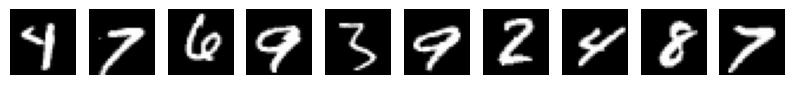

In [6]:
start = np.random.randint (0, 60000)

plt.figure (figsize = (10,20), dpi = 100)
for i in range(10):
  plt.subplot (1, 10, i+1)
  plt.imshow (train_img[start + i,:,:,0], cmap = "gray")
  plt.axis ("off")
plt.show()

To help the neural networks to consume data efficiently during the training procedure, it's useful prepare it within [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_ds = ( 
  tf.data.Dataset.from_tensor_slices ( train_img )
  .shuffle ( BUFFER_SIZE )                       # shuffle all the images
  .batch ( BATCH_SIZE, drop_remainder = True )   # mini-batch splitting
  #.cache()                                       # cache the dataset
  #.prefetch ( tf.data.AUTOTUNE )   # pre-prepare data to be consumed
)

test_ds = ( 
  tf.data.Dataset.from_tensor_slices ( test_img )
  .shuffle ( BUFFER_SIZE )                       # shuffle all the images
  .batch ( BATCH_SIZE, drop_remainder = True )   # mini-batch splitting
  #.cache()                                       # cache the dataset
  #.prefetch ( tf.data.AUTOTUNE )   # pre-prepare data to be consumed
)

### Create the adversarial players

Both the generator and the discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model).

#### The generator

The generator uses [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (sometimes called **deconvolutional**) layers to produce an image from the latent space $\mathcal{Z}$. Start with a `Dense` layer that takes $z$ elements as input, then upsample several times until to reach the desired image size of 28x28x1. Notice the [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer, except the output layer which uses $\tanh$.

In [9]:
LATENT_DIM = 100

In [10]:
generator = Sequential ( name = "generator" )

generator . add ( layers.Dense ( 7 * 7 * 256, use_bias = False, input_shape = (LATENT_DIM,) ) )
generator . add ( layers.BatchNormalization() )
generator . add ( layers.LeakyReLU ( alpha = 0.2 ) )

generator . add ( layers.Reshape ( (7, 7, 256) ) )

generator . add ( layers.Conv2DTranspose ( 128, (5, 5), strides = (1, 1), padding = "same", use_bias = False ) )
generator . add ( layers.BatchNormalization() )
generator . add ( layers.LeakyReLU ( alpha = 0.2 ) )

generator . add ( layers.Conv2DTranspose ( 64, (5, 5), strides = (2, 2), padding = "same", use_bias = False ) )
generator . add ( layers.BatchNormalization() )
generator . add ( layers.LeakyReLU ( alpha = 0.2 ) )

generator . add ( layers.Conv2DTranspose ( 1, (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = "tanh" ) )

Use the (as yet untrained) generator to create an image.

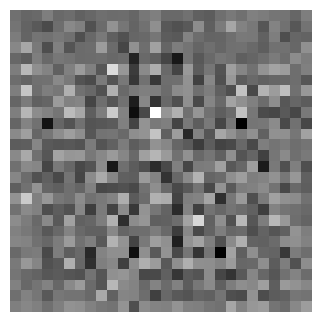

In [11]:
z = tf.random.normal ( shape = [1, 100] )
gen_image = generator ( z, training = False )

plt.figure (figsize = (4,4), dpi = 100)
plt.imshow (gen_image[0, :, :, 0], cmap = "gray")
plt.axis ("off")
plt.show()

#### The discriminator

The discriminator is a CNN-based image classifier.

In [12]:
discriminator = Sequential ( name = "discriminator" )
    
discriminator . add ( layers.Conv2D ( 64, (5, 5), strides = (2, 2), padding = "same", input_shape = [28, 28, 1] ) )
discriminator . add ( layers.LeakyReLU ( alpha = 0.2 ) )
discriminator . add ( layers.Dropout (0.3) )

discriminator . add ( layers.Conv2D ( 128, (5, 5), strides = (2, 2), padding = "same" ) )
discriminator . add ( layers.LeakyReLU ( alpha = 0.2 ) )
discriminator . add ( layers.Dropout (0.3) )

discriminator . add ( layers.Flatten() )
discriminator . add ( layers.Dense ( 1, activation = "sigmoid" ) )

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output the probability that the input is a real image.

In [13]:
discriminator ( gen_image ) . numpy()

array([[0.5003296]], dtype=float32)

### Training procedure

The training procedure is implemented through the `GAN` class provided by the [`tf-gen-models` package](https://pypi.org/project/tf-gen-models/). The network learning is driven by the loss function previously described [[1](https://arxiv.org/abs/1406.2661)], while the training is stabilized thanks to a noise injection [[2](https://arxiv.org/abs/1701.04862)].

In [14]:
gan = GAN (generator, discriminator, latent_dim = LATENT_DIM)

The architecture chosen for the two players can be recovered through the `summary()` method.

In [15]:
gan . summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        51

#### Generator and discriminator optimizers

The discriminator and the generator **optimizers** are different since we will train two networks separately (even if simultaneously).

In [16]:
G_LR = 1e-4
D_LR = 1e-4

In [17]:
g_opt = tf.keras.optimizers.Adam ( G_LR )
d_opt = tf.keras.optimizers.Adam ( D_LR )

gan . compile ( g_optimizer = g_opt , 
                d_optimizer = d_opt , 
                g_updt_per_batch = 1 , 
                d_updt_per_batch = 1 )

In order to reach the minimum _quickly_ and _safely_, the learning rate should be decreased gradually during the training. The `GanLrScheduler` class implements an **exponential decay**, where `factor` represents the decay rate and `step` corresponds to the decay step.

In [18]:
lr_sched = GanExpLrScheduler ( factor = 0.95, step = 10 )

#### Custom callbacks

A callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. For instance, the `GanLrScheduler` class mentioned above inherits from the [`tf.keras.callbacks.Callback`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) class. The `tf-gen-models` package offers more callbacks to customize the training procedure, like `ImageSaver` and `ModelSaver`:

* `ImageSaver` allows to save the generator output (more precisely, a 4x4 matrix of digit images) once every `step` epochs;
* `ModelSaver` allows to save a checkpoint of the generator and/or discriminator models once every `step` epochs.

To learn more about custom callbacks, refers to the [TensorFlow guide](https://www.tensorflow.org/guide/keras/custom_callback).

In [19]:
img_saver = ImageSaver ( name = "dc-gan", step = 1 )

In [20]:
mod_saver = ModelSaver ( name = "dc-gan", step = 10 )

#### Minimax game

The `GAN` class inherits from the [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) and implements a [custom `fit()` function](https://keras.io/guides/customizing_what_happens_in_fit/). Calling the `fit()` method, every mini-batch of data the discriminator loss function is computed and network weights updated for `d_updt_per_batch` times, then the generator loss is computed and relative weights updated for `g_updt_per_batch` times. Note, training GANs can be _tricky_. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real (even if **mode collapse** may occur). After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on [Google Colab](https://colab.research.google.com/).

In [21]:
EPOCHS = 10
STEPS_PER_EPOCH = int ( len(train_img) / BATCH_SIZE )

In [22]:
train = gan . fit ( train_ds , 
                    epochs = EPOCHS ,
                    steps_per_epoch = STEPS_PER_EPOCH ,
                    validation_data = test_ds ,
                    callbacks = [ lr_sched, img_saver, mod_saver ] ,
                    verbose = 1 )

Epoch 1/10
  7/234 [..............................] - ETA: 24:12 - mse: 0.9031 - g_loss: -0.3259 - d_loss: 0.3258 - g_lr: 1.0000e-04 - d_lr: 1.0000e-04

KeyboardInterrupt: ignored

#### Learning and metric curves

In [ ]:
fig, ax = plt.subplots (1, 2, figsize = (15,5), dpi = 100)
plt.subplots_adjust (wspace = 0.2)

ax[0] . set_title ("Learning curves", fontsize = 14)
ax[0] . set_xlabel ("Training epochs", fontsize = 12)
ax[0] . set_ylabel (f"{gan.loss_name}", fontsize = 12)
ax[0] . plot (train.history["g_loss"], linewidth = 1.5, color = "coral", label = "generator")
ax[0] . plot (train.history["d_loss"], linewidth = 1.5, color = "dodgerblue", label = "discriminator")
ax[0] . legend (loc = "upper right", fontsize = 10)

ax[1] . set_title ("Metric curves", fontsize = 14)
ax[1] . set_xlabel ("Training epochs", fontsize = 12)
ax[1] . set_ylabel ("Mean square error", fontsize = 12)
ax[1] . plot (train.history["mse"], linewidth = 1.5, color = "forestgreen", label = "training set")
ax[1] . plot (train.history["val_mse"], linewidth = 1.5, color = "orangered", label = "validation set")
ax[1] . legend (loc = "upper right", fontsize = 10)

plt.show()

#### Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image (epoch):
  return PIL.Image.open (f"./images/dc-gan_ep{epoch:04d}.png")

In [ ]:
display_image (EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = "dc-gan.gif"

with imageio.get_writer (anim_file, mode = "I") as writer:
  filenames = glob.glob ("./images/dc-gan_ep*.png")
  filenames = sorted (filenames)
  for filename in filenames:
    image = imageio.imread (filename)
    writer.append_data (image)
  image = imageio.imread (filename)
  writer.append_data (image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file (anim_file)

## Next steps

To learn more about GANs see the [notebooks](https://github.com/mbarbetti/tf-gen-models/tree/main/notebooks) section of the `tf-gen-models` [GitHub repository](https://github.com/mbarbetti/tf-gen-models).

## References

1.  I. J. Goodfellow _et al._, "Generative Adversarial Nets", [arXiv:1406.2661](https://arxiv.org/abs/1406.2661).
2. M. Arjovsky and L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862](https://arxiv.org/abs/1701.04862).
3. A. Brock, J. Donahue and K. Simonyan, "Large Scale GAN Training for High Fidelity Natural Image Synthesis", [arXiv:1809.11096](https://arxiv.org/abs/1809.11096).
4. A. Radford, L. Metz and S. Chintala, "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks", [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)